In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/sample_submission.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train.zip
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv


In [5]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, SCORERS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import random
import xgboost as xgb
from xgboost import XGBClassifier

In [12]:
train_session = pd.read_csv("/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv")
test_session = pd.read_csv("/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv")
site_dic = pd.read_pickle("/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl")

In [4]:
train_session.sample(10)

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
11699,11700,1308,2014-01-03 11:25:36,1310.0,2014-01-03 11:25:41,1311.0,2014-01-03 11:25:41,1308.0,2014-01-03 11:25:41,1310.0,...,2014-01-03 11:25:42,29.0,2014-01-03 11:25:42,1312.0,2014-01-03 11:25:43,1315.0,2014-01-03 11:25:43,22.0,2014-01-03 11:25:43,0
187016,187017,3290,2014-03-19 11:55:15,3290.0,2014-03-19 11:55:16,3290.0,2014-03-19 11:55:17,3290.0,2014-03-19 11:55:18,3290.0,...,2014-03-19 11:55:21,3290.0,2014-03-19 11:55:22,3290.0,2014-03-19 11:55:24,3290.0,2014-03-19 11:55:25,3290.0,2014-03-19 11:55:26,0
155689,155690,167,2013-12-19 15:20:28,3.0,2013-12-19 15:20:33,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
26225,26226,26,2014-01-28 14:17:21,29.0,2014-01-28 14:17:21,46.0,2014-01-28 14:17:21,119.0,2014-01-28 14:17:22,31.0,...,2014-01-28 14:17:22,33.0,2014-01-28 14:17:22,36.0,2014-01-28 14:17:22,35.0,2014-01-28 14:17:22,46.0,2014-01-28 14:17:22,0
91674,91675,21,2014-03-27 10:37:02,21.0,2014-03-27 10:37:03,23.0,2014-03-27 10:37:03,39.0,2014-03-27 10:37:04,775.0,...,2014-03-27 10:37:05,677.0,2014-03-27 10:37:05,679.0,2014-03-27 10:37:05,676.0,2014-03-27 10:37:05,616.0,2014-03-27 10:37:05,0
174432,174433,940,2014-04-02 14:42:17,812.0,2014-04-02 14:42:17,676.0,2014-04-02 14:42:17,23.0,2014-04-02 14:42:17,679.0,...,2014-04-02 14:42:17,940.0,2014-04-02 14:42:20,941.0,2014-04-02 14:42:21,942.0,2014-04-02 14:42:21,940.0,2014-04-02 14:42:21,0
108922,108923,21,2014-02-24 08:43:07,707.0,2014-02-24 08:43:07,21.0,2014-02-24 08:43:25,21.0,2014-02-24 08:43:31,21.0,...,2014-02-24 08:43:34,38.0,2014-02-24 08:43:35,30867.0,2014-02-24 08:43:35,21.0,2014-02-24 08:43:35,30867.0,2014-02-24 08:43:36,0
80106,80107,782,2014-03-17 10:28:17,782.0,2014-03-17 10:28:47,780.0,2014-03-17 10:28:56,780.0,2014-03-17 10:28:58,780.0,...,2014-03-17 10:29:17,780.0,2014-03-17 10:29:40,780.0,2014-03-17 10:29:41,780.0,2014-03-17 10:29:43,780.0,2014-03-17 10:29:44,0
79557,79558,1048,2014-01-14 11:03:10,32.0,2014-01-14 11:03:10,30.0,2014-01-14 11:03:10,7606.0,2014-01-14 11:03:10,7604.0,...,2014-01-14 11:03:11,29.0,2014-01-14 11:03:12,7609.0,2014-01-14 11:03:12,33.0,2014-01-14 11:03:12,35.0,2014-01-14 11:03:12,0
60522,60523,639,2014-01-04 09:08:05,15116.0,2014-01-04 09:08:12,15116.0,2014-01-04 09:08:20,1933.0,2014-01-04 09:08:25,1934.0,...,2014-01-04 09:08:36,1941.0,2014-01-04 09:08:36,1930.0,2014-01-04 09:08:37,1950.0,2014-01-04 09:08:37,1929.0,2014-01-04 09:09:05,0


In [5]:
print("length of sites :",len(site_dic.keys()))
print("start num :", min(site_dic.values()))
print("end num :", max(site_dic.values()))

length of sites : 48371
start num : 1
end num : 48371


In [6]:
train_session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19  si

In [7]:
test_session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82797 entries, 0 to 82796
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   session_id  82797 non-null  int64  
 1   site1       82797 non-null  int64  
 2   time1       82797 non-null  object 
 3   site2       81308 non-null  float64
 4   time2       81308 non-null  object 
 5   site3       80075 non-null  float64
 6   time3       80075 non-null  object 
 7   site4       79182 non-null  float64
 8   time4       79182 non-null  object 
 9   site5       78341 non-null  float64
 10  time5       78341 non-null  object 
 11  site6       77566 non-null  float64
 12  time6       77566 non-null  object 
 13  site7       76840 non-null  float64
 14  time7       76840 non-null  object 
 15  site8       76151 non-null  float64
 16  time8       76151 non-null  object 
 17  site9       75484 non-null  float64
 18  time9       75484 non-null  object 
 19  site10      74806 non-nul

### site_dict에 site id는 integer로 되어 있으므로 Float -> int 변환

In [8]:
# Float to Integer
# astype으로 Float -> Integer 하려고 하면 NaN값 때문에 에러뜸
# IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer
# 따라서 fillna 먼저 해주고 변환 수행
train_session.fillna(value=0, inplace=True)
train_session[train_session.columns[train_session.dtypes == 'float64']] = train_session[train_session.columns[train_session.dtypes == 'float64']].astype('int')

In [9]:
# integer 변환 확인
train_session.sample(10)

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
243610,243611,1039,2014-03-31 17:48:40,1039,2014-03-31 17:51:45,812,2014-03-31 17:51:47,812,2014-03-31 17:54:03,1039,...,2014-03-31 17:56:25,1039,2014-03-31 17:56:35,812,2014-03-31 17:57:47,774,2014-03-31 18:00:25,1039,2014-03-31 18:00:35,0
46406,46407,75,2013-02-12 08:51:58,197,2013-02-12 08:51:59,39282,2013-02-12 08:51:59,39283,2013-02-12 08:51:59,52,...,2013-02-12 08:52:01,39282,2013-02-12 08:52:02,39282,2013-02-12 08:52:03,4313,2013-02-12 08:54:01,3110,2013-02-12 08:54:02,0
39159,39160,1,2014-01-14 13:35:22,63,2014-01-14 13:35:25,167,2014-01-14 13:35:29,23,2014-01-14 13:35:30,29,...,2014-01-14 13:36:05,66,2014-01-14 13:37:15,63,2014-01-14 13:38:23,29,2014-01-14 13:50:53,29,2014-01-14 13:51:33,0
203722,203723,53,2013-12-12 12:38:14,52,2013-12-12 12:38:14,52,2013-12-12 12:38:15,2736,2013-12-12 12:38:17,21,...,2013-12-12 12:38:18,48,2013-12-12 12:38:19,2736,2013-12-12 12:38:19,2740,2013-12-12 12:38:19,2738,2013-12-12 12:38:19,0
209284,209285,52,2013-11-26 10:40:36,52,2013-11-26 10:40:38,23,2013-11-26 10:40:39,52,2013-11-26 10:40:39,23,...,2013-11-26 10:40:50,52,2013-11-26 10:40:51,52,2013-11-26 10:41:11,52,2013-11-26 10:41:12,52,2013-11-26 10:41:14,0
16774,16775,21,2014-02-18 14:37:25,23,2014-02-18 14:37:27,242,2014-02-18 14:37:27,38,2014-02-18 14:37:27,23,...,2014-02-18 14:37:28,38,2014-02-18 14:37:28,242,2014-02-18 14:37:29,182,2014-02-18 14:37:30,242,2014-02-18 14:37:30,0
46375,46376,322,2013-12-16 15:56:07,23,2013-12-16 15:56:08,2826,2013-12-16 15:56:09,21,2013-12-16 15:56:09,325,...,2013-12-16 15:56:10,25309,2013-12-16 15:56:10,510,2013-12-16 15:56:10,515,2013-12-16 15:56:10,324,2013-12-16 15:56:10,0
169101,169102,201,2014-02-17 12:45:40,812,2014-02-17 12:48:07,812,2014-02-17 12:50:25,812,2014-02-17 12:53:07,812,...,2014-02-17 12:55:12,812,2014-02-17 12:59:01,774,2014-02-17 12:59:02,812,2014-02-17 12:59:02,570,2014-02-17 12:59:02,0
20752,20753,2868,2013-12-18 15:06:35,2868,2013-12-18 15:06:36,896,2013-12-18 15:06:36,2868,2013-12-18 15:06:37,335,...,2013-12-18 15:06:39,2814,2013-12-18 15:06:39,2815,2013-12-18 15:06:39,2868,2013-12-18 15:06:42,335,2013-12-18 15:06:48,0
239925,239926,35,2014-04-14 10:04:53,38894,2014-04-14 10:04:53,33,2014-04-14 10:04:53,29,2014-04-14 10:04:53,17179,...,2014-04-14 10:04:54,17179,2014-04-14 10:04:55,17179,2014-04-14 10:04:56,14876,2014-04-14 10:04:57,29,2014-04-14 10:05:00,0


In [10]:
# train의 Target 분포 확인
print("--------train data's target dist--------\n")
print(train_session['target'].value_counts(), '\n\n')

# site 분포 확인
site_cols = [x for x in list(train_session.columns) if x[:4] == 'site']
sites = train_session[site_cols].values.ravel()
cnts = Counter(sites).most_common()

print("--------top 20 most frequent values--------\n")
for i in range(20):
    print(f"{i+1}th: {cnts[i][0]} --> {cnts[i][1]}")
print("\n\n--------sites descriptive statistics--------\n")
print("sites std  :", np.std(sites))
print("sties mean :", np.mean(sites))

--------train data's target dist--------

0    251264
1      2297
Name: target, dtype: int64 


--------top 20 most frequent values--------

1th: 21 --> 123776
2th: 0 --> 122730
3th: 23 --> 87619
4th: 782 --> 77055
5th: 22 --> 58258
6th: 29 --> 54094
7th: 167 --> 46405
8th: 780 --> 43841
9th: 778 --> 38194
10th: 52 --> 36085
11th: 812 --> 35178
12th: 80 --> 31391
13th: 570 --> 30616
14th: 55 --> 27812
15th: 39 --> 25275
16th: 37 --> 23726
17th: 30 --> 23495
18th: 786 --> 23026
19th: 35 --> 22470
20th: 76 --> 20922


--------sites descriptive statistics--------

sites std  : 7244.004573897046
sties mean : 3192.146703948951


## 시간과 target간의 관계 확인
- time1값(NaN이 없는 유일한 column)을 기준으로 hour로 구분해서 target distribution 확인

In [11]:
temp = train_session[['time1','target']]
temp['time1'] = temp['time1'].apply(lambda x: int(x[11:13]) if type(x) != int else -1)
temp_temp = temp.groupby('time1').sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


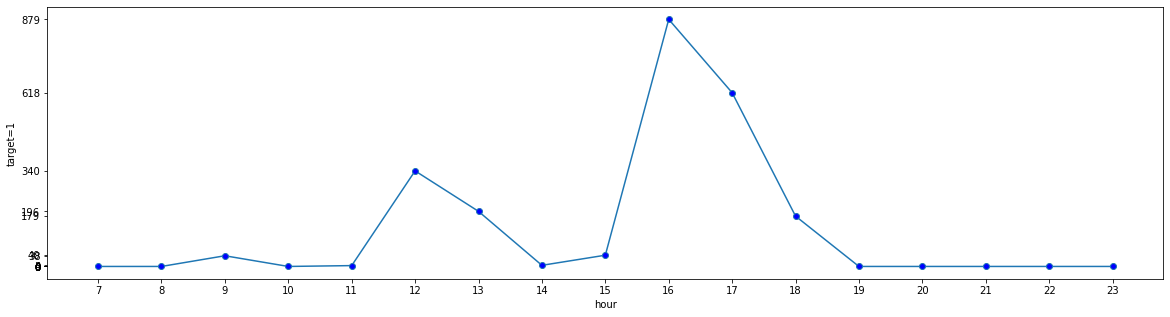

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(temp_temp.index, temp_temp['target'],marker='o', markerfacecolor='blue',markersize=6)
plt.xlabel('hour')
plt.xticks(temp_temp.index)
plt.yticks(temp_temp['target'])
plt.ylabel('target=1')
plt.show()

## hour별 target distribution -> 12-13 16-18시에 집중됨

### 빈도수가 상위 K개인 site들만 활용할 방법

In [13]:
## site id를 상위 k개만 뽑아서 사용하면?
temp_sum = 0
step = 0
length = len(sites)

for i in range(1, 1000000):
    temp_sum += cnts[i][1]
    rate = temp_sum/length
    if i % 100 == 0:
        print(f"top {i} sites rate: {rate}")
    if rate > 0.9:
        print(f"top {i} sites ratio is 90%")
        break

top 100 sites rate: 0.5610235801247038
top 200 sites rate: 0.6396882801377184
top 300 sites rate: 0.6828017715658166
top 400 sites rate: 0.7119931692965401
top 500 sites rate: 0.733573380764392
top 600 sites rate: 0.7506497450317675
top 700 sites rate: 0.7646286297971692
top 800 sites rate: 0.7763804370545944
top 900 sites rate: 0.7864095819151999
top 1000 sites rate: 0.7949925264532006
top 1100 sites rate: 0.8024455653669137
top 1200 sites rate: 0.8090345124052989
top 1300 sites rate: 0.81496326327787
top 1400 sites rate: 0.8203635417118563
top 1500 sites rate: 0.8253047590126242
top 1600 sites rate: 0.829820832068023
top 1700 sites rate: 0.833941733941734
top 1800 sites rate: 0.8377510737061299
top 1900 sites rate: 0.8412835570138941
top 2000 sites rate: 0.8445525928671996
top 2100 sites rate: 0.8476086622154038
top 2200 sites rate: 0.8504844987991056
top 2300 sites rate: 0.8531994273567307
top 2400 sites rate: 0.8557739557739558
top 2500 sites rate: 0.8582025626969447
top 2600 sites

## 단순 모델로 성능 테스트
- 별도의 Hyperparameter tuning없이 했을 때 성능
- RF -> 0.53
- XGB -> 0.60

In [8]:
def preprocess(raw_data:pd.DataFrame, test=False, impute='zero') -> pd.DataFrame:
    
    data = raw_data.copy()
    
    # make new feature : 'hour'
    data['hour'] = data['time1'].apply(lambda x:int(x[11:13]))
    
    # drop time columns
    cols = list(data.columns.values)
    time_cols = [x for x in cols if x[:4] == 'time']
    data.drop(time_cols, inplace=True, axis=1)
      
    # impute
    # 1: id의 비율에 따라 random하게 집어넣기
    
    
    # fillna -> default : zero
    data.fillna(value=0, inplace=True)
    
    # row별 최빈값으로 대체
    
    
    # Float To Int
    data[data.columns[data.dtypes == 'float64']] = data[data.columns[data.dtypes == 'float64']].astype('int')
    
    if test:
        return data
    y = data['target']
    X = data.drop(['target'], axis=1)
    
    return X, y

In [9]:
raw_train = pd.read_csv("/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv")

In [10]:
X, y = preprocess(raw_train)

In [13]:
test_data = preprocess(test_session, test=True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [56]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [19]:
xgb = XGBClassifier(n_estimators=1000,learing_rate=0.02,eval_metric='auc',reg_alpha=10, reg_lambda=2,random_state=10,tree_method='gpu_hist', gpu_id=0)

In [21]:
model = LogisticRegression(penalty='l2', C=4)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred.ravel())

0.2676778178075142

In [19]:
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict_proba(X_test)[:, 1]
print("xgb roc_auc score:", roc_auc_score(y_test, pred_xgb.ravel()))

AttributeError: module 'xgboost' has no attribute 'fit'

In [20]:
xgb.fit(X, y)

[09:29:26] WARNING: ../src/learner.cc:627: 
Parameters: { "learing_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learing_rate=0.02, learning_rate=0.300000012, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=10, reg_alpha=10, ...)

In [61]:
## confusion matrix 분석
TN, FP, FN, TP = confusion_matrix(y_test, pred_xgb).ravel()
print(confusion_matrix(y_test, pred_xgb))

[[25104    21]
 [  185    47]]


In [56]:
#cross_val_score(model, X, y, cv=5, scoring='roc_auc')

In [123]:
std_forest = RandomForestClassifier(random_state=10, n_jobs=-1)
std_forest.fit(X_train, y_train)
pred_forest = std_forest.predict_prob(X_test)
print("forest roc_auc score:", roc_auc_score(y_test, pred_forest))

KeyboardInterrupt: 

In [64]:
pip install imbalance-xgboost

Note: you may need to restart the kernel to use updated packages.


In [114]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import GridSearchCV

xgboster_focal = imb_xgb(special_objective='focal')
xgboster_weight = imb_xgb(special_objective='weighted')
CV_focal_booster = GridSearchCV(xgboster_focal, {"focal_gamma":[1.0,1.5,2.0,2.5,3.0]})
CV_weight_booster = GridSearchCV(xgboster_weight, {"imbalance_alpha":[1.5,2.0,2.5,3.0,4.0]})

In [115]:
CV_focal_booster.fit(X_train.values, y_train.ravel())
CV_weight_booster.fit(X_train.values, y_train.ravel())
opt_focal_booster = CV_focal_booster.best_estimator_
opt_weight_booster = CV_weight_booster.best_estimator_

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:571: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning
/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:571: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning
/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different be

In [104]:
xgboster_focal = imb_xgb(special_objective='focal',focal_gamma=3.0)

In [105]:
xgboster_focal.fit(X_train.values, y_train.ravel())

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:571: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning
/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


In [121]:
focal_pred = opt_focal_booster.predict_determine(X_test)
weight_pred = opt_weight_booster.predict_determine(X_test)

In [122]:
print("focal:", roc_auc_score(y_test, focal_pred))
print("weight:", roc_auc_score(y_test, weight_pred))

focal: 0.5623009950248756
weight: 0.5895620174987134


## False Negative 비율 높음 -> 모델이 전부 0이라고 하는 중

In [100]:
xgboster_focal.fit(X.values, y.ravel())

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:571: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning
/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


In [21]:
def make_submission(model, test_data) -> None:
    
    temp = pd.DataFrame()
    temp.index = test_data.index
    temp['session_id'] = test_data['session_id']
    pred = model.predict_proba(test_data)[:, 1]
    temp['target'] = pred
    
    temp.to_csv("submission.csv", index=False)

In [22]:
make_submission(xgb, test_data)